In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.isotonic import IsotonicRegression
from scipy.spatial import distance
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def ridge_func(x):
    return np.maximum(0, x)
    
def generate_synthetic_data(n, d, alpha_0_true, noise_scale=0.2, distribution='uniform', gamma_shape=2.0, gamma_scale=1.0):
    np.random.seed(567)
    if distribution == 'uniform':
        X = np.random.rand(n, d)  # Uniform distribution in [0, 1)
    elif distribution == 'normal':
        X = np.random.randn(n, d)  # Standard normal distribution
    elif distribution == 'gamma':
        X = np.random.gamma(gamma_shape, gamma_scale, (n, d))  # Gamma distribution
    else:
        raise ValueError("Unsupported distribution type. Please choose either 'uniform', 'normal', or 'gamma'.")
    
    Y = ridge_func(X.dot(alpha_0_true)) + np.random.normal(scale=noise_scale, size=n)
    return X, Y

def find_orthogonal_vectors(X):
    n, d = X.shape
    orthogonal_vectors = set()
    for i in range(n):
        for j in range(i + 1, n):
            diff = X[j] - X[i]
            ortho_vector = np.array([-diff[1], diff[0]])  # For d=2
            ortho_vector /= np.linalg.norm(ortho_vector)  # Normalize
            orthogonal_vectors.add(tuple(ortho_vector))
    return np.array(list(orthogonal_vectors))

def compute_mse(Y_true, Y_pred):
    return np.mean((Y_true - Y_pred)**2)


### Uniform(0,1) distributed X

In [12]:
# Generate synthetic data
n, d = 200, 2
alpha_0_true = np.array([1, -1])
alpha_0_true = alpha_0_true/np.linalg.norm(alpha_0_true) 
X, Y = generate_synthetic_data(n, d, alpha_0_true, distribution = 'uniform')

# Find orthogonal vectors
orthogonal_vectors = find_orthogonal_vectors(X)

# Main algorithm loop
best_mse = np.inf
best_alpha = None
best_Y_pred = None

for alpha in orthogonal_vectors:
    # Project X onto alpha
    projected_X = X.dot(alpha)
    
    # Apply isotonic regression
    iso_reg = IsotonicRegression(increasing=True, out_of_bounds='clip')
    Y_pred = iso_reg.fit_transform(projected_X, Y)

    # Compute MSE and update best alpha if needed
    mse = compute_mse(Y, Y_pred)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_iso_reg = iso_reg
        best_Y_pred = Y_pred

print("Ground Truth Alpha: ", alpha_0_true)
print("Best alpha:", best_alpha)
print("MSE:", best_mse)


Ground Truth Alpha:  [ 0.70710678 -0.70710678]
Best alpha: [ 0.71150952 -0.70267646]
MSE: 0.038247644397337924


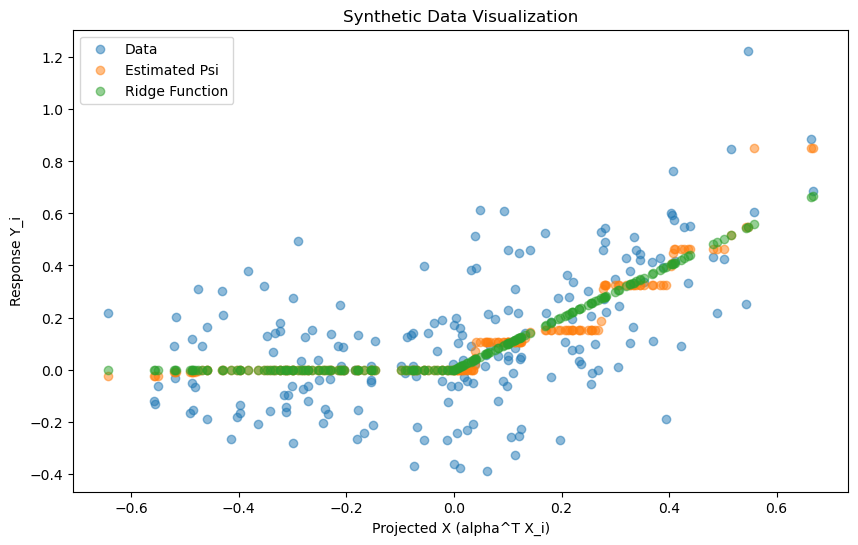

In [13]:
# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.scatter(X.dot(alpha_0_true), best_iso_reg.predict( X.dot(alpha_0_true) ), alpha=0.5, label='Estimated Psi')
plt.scatter(X.dot(alpha_0_true), ridge_func(X.dot(alpha_0_true)), alpha=0.5, label='Ridge Function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('Synthetic Data Visualization')
plt.legend()
plt.show()


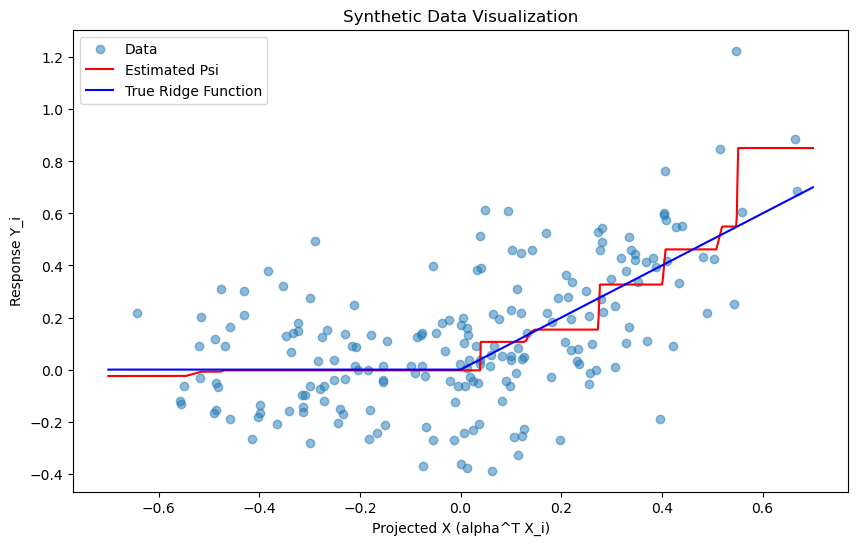

In [14]:
points = np.linspace(-0.7, 0.7, 1000)

# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.plot(points, best_iso_reg.predict(points), color='red', label='Estimated Psi')
plt.plot(points, ridge_func(points), color='blue', label='True Ridge Function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('Synthetic Data Visualization')
plt.legend()
plt.show()


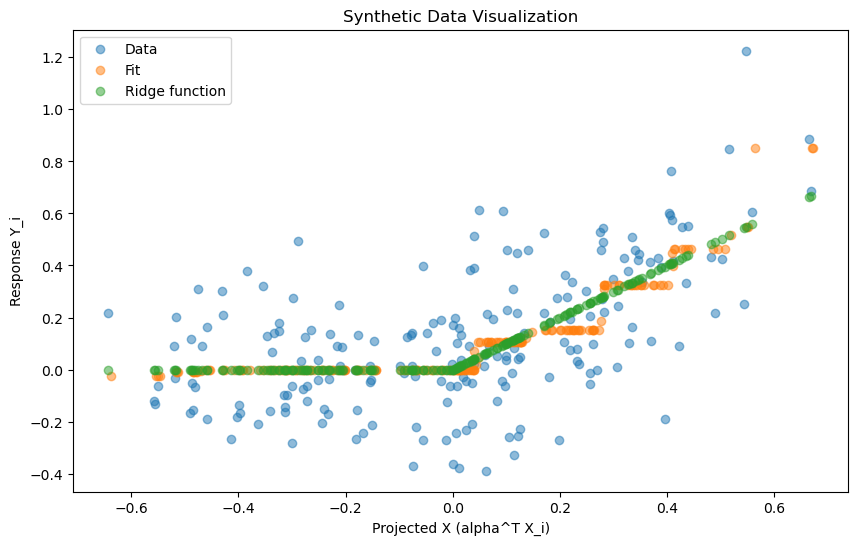

In [15]:
# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.scatter(X.dot(best_alpha), best_iso_reg.predict( X.dot(alpha_0_true) ), alpha=0.5, label='Fit')
plt.scatter(X.dot(alpha_0_true), ridge_func(X.dot(alpha_0_true)), alpha=0.5, label='Ridge function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('Synthetic Data Visualization')
plt.legend()
plt.show()


In [16]:
def mse_for_different_n(n_values, alpha_0_true, distr, d=2, noise_scale=0.2):
    mse_values = []
    X, Y = generate_synthetic_data(1000, d, alpha_0_true, noise_scale=noise_scale, distribution=distr)
    for n in n_values:
        X_new = X[:n]
        Y_new = Y[:n]
        
        # Find orthogonal vectors
        orthogonal_vectors = find_orthogonal_vectors(X_new)

        # Main algorithm loop
        best_mse = np.inf
        for alpha in orthogonal_vectors:
            # Project X onto alpha
            projected_X = X_new.dot(alpha)
                        
            # Apply isotonic regression
            iso_reg = IsotonicRegression(increasing=True, out_of_bounds='clip').fit(projected_X, Y_new)
            Y_pred = iso_reg.predict(X.dot(alpha))
                        
            # Compute MSE and update best alpha if needed
            mse = mean_squared_error(Y, Y_pred)
            if mse < best_mse:
                best_mse = mse

        mse_values.append(best_mse)
    return mse_values

# Define the parameters
n_values = [50, 100, 150]

# Compute MSE values for different n
mse_values = mse_for_different_n(n_values, alpha_0_true, distr='uniform')

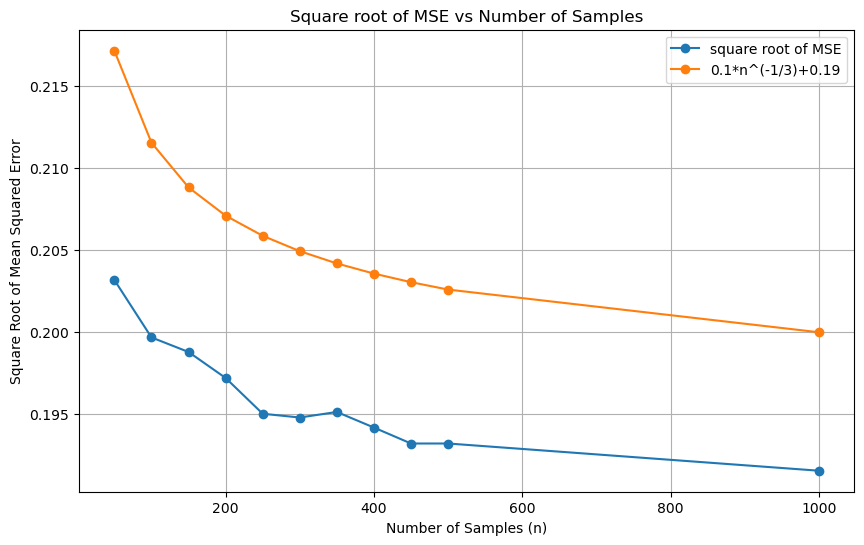

In [17]:
mse_sqrt_values = np.sqrt(mse_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_sqrt_values, marker='o', label="square root of MSE")
plt.plot(n_values, 0.1*np.array(n_values)**(-1/3)+0.19, marker='o', label = "0.1*n^(-1/3)+0.19")
plt.xlabel('Number of Samples (n)')
plt.ylabel('Square Root of Mean Squared Error')
plt.title('Square root of MSE vs Number of Samples')
plt.grid(True)
plt.legend()
plt.show()

### Gaussian Distributed X

In [18]:
# Generate synthetic data
X, Y = generate_synthetic_data(n, d, alpha_0_true, distribution='normal')

# Find orthogonal vectors
orthogonal_vectors = find_orthogonal_vectors(X)

# Main algorithm loop
best_mse = np.inf
best_alpha = None
best_Y_pred = None

for alpha in orthogonal_vectors:
    # Project X onto alpha
    projected_X = X.dot(alpha)
    
    # Apply isotonic regression
    iso_reg = IsotonicRegression(increasing=True, out_of_bounds='clip')
    Y_pred = iso_reg.fit_transform(projected_X, Y)

    # Compute MSE and update best alpha if needed
    mse = compute_mse(Y, Y_pred)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_iso_reg = iso_reg
        best_Y_pred = Y_pred

print("Ground Truth Alpha: ", alpha_0_true)
print("Best alpha:", best_alpha)
print("MSE:", best_mse)


Ground Truth Alpha:  [ 0.70710678 -0.70710678]
Best alpha: [ 0.72499549 -0.68875361]
MSE: 0.032721288940675


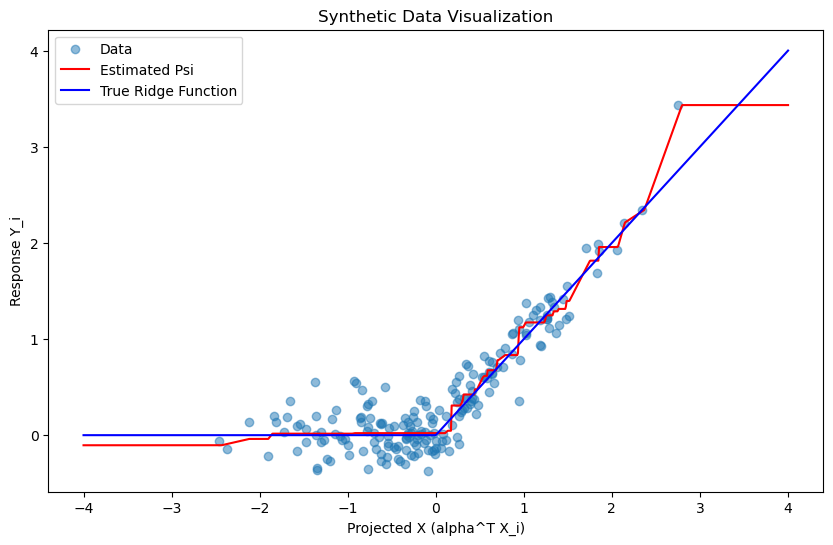

In [19]:
points = np.linspace(-4, 4, 1000)

# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.plot(points, best_iso_reg.predict(points), color='red', label='Estimated Psi')
plt.plot(points, ridge_func(points), color='blue', label='True Ridge Function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('Synthetic Data Visualization')
plt.legend()
plt.show()


In [20]:
# Define the parameters
n_values = [50, 100, 150, 200, 250, 300, 350, 400, 450,500, 1000]

# Compute MSE values for different n
mse_values = mse_for_different_n(n_values, alpha_0_true, distr = "normal")

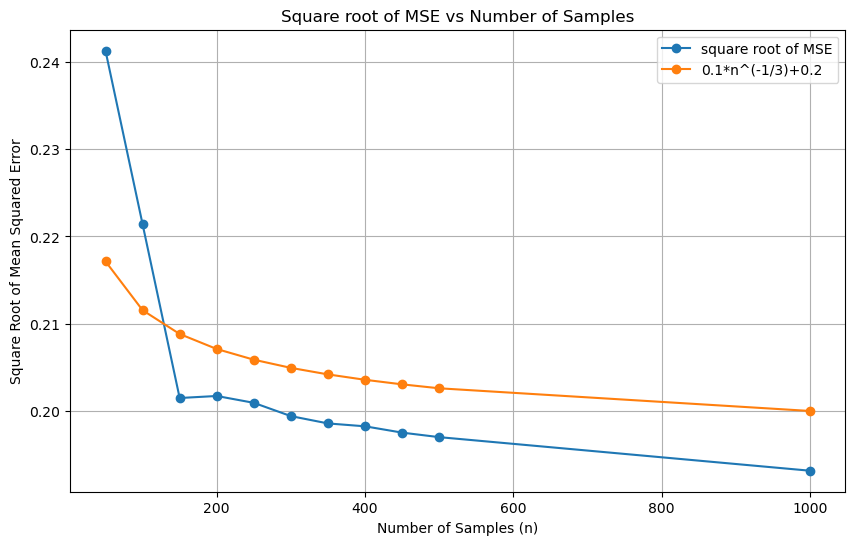

In [21]:
mse_sqrt_values = np.sqrt(mse_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_sqrt_values, marker='o', label="square root of MSE")
plt.plot(n_values, 0.1*np.array(n_values)**(-1/3)+0.19, marker='o', label = "0.1*n^(-1/3)+0.2")
plt.xlabel('Number of Samples (n)')
plt.ylabel('Square Root of Mean Squared Error')
plt.title('Square root of MSE vs Number of Samples')
plt.grid(True)
plt.legend()
plt.show()

### Gamma distributed X

In [22]:
# Generate synthetic data
X, Y = generate_synthetic_data(n, d, alpha_0_true, distribution='gamma')

# Find orthogonal vectors
orthogonal_vectors = find_orthogonal_vectors(X)

# Main algorithm loop
best_mse = np.inf
best_alpha = None
best_Y_pred = None

for alpha in orthogonal_vectors:
    # Project X onto alpha
    projected_X = X.dot(alpha)
    
    # Apply isotonic regression
    iso_reg = IsotonicRegression(increasing=True, out_of_bounds='clip')
    Y_pred = iso_reg.fit_transform(projected_X, Y)

    # Compute MSE and update best alpha if needed
    mse = compute_mse(Y, Y_pred)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_iso_reg = iso_reg
        best_Y_pred = Y_pred

print("Ground Truth Alpha: ", alpha_0_true)
print("Best alpha:", best_alpha)
print("MSE:", best_mse)


Ground Truth Alpha:  [ 0.70710678 -0.70710678]
Best alpha: [ 0.7104997 -0.7036975]
MSE: 0.031898694453665166


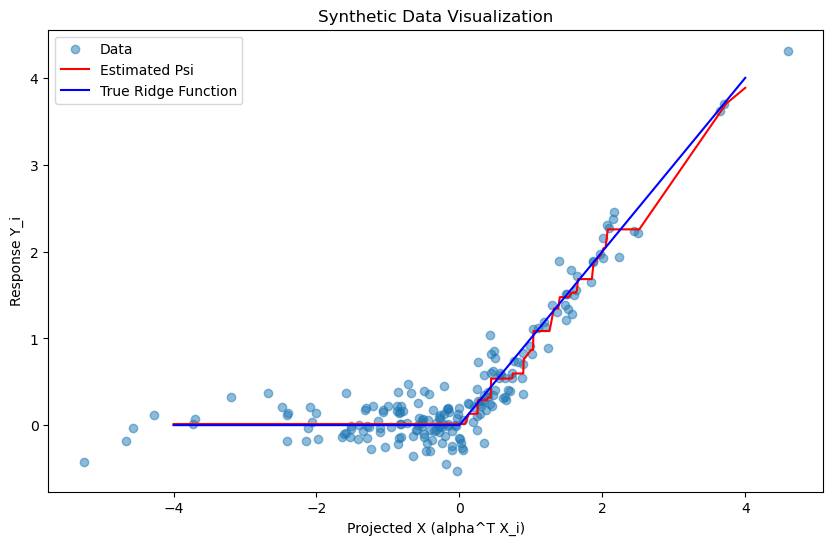

In [23]:
points = np.linspace(-4, 4, 1000)

# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.plot(points, best_iso_reg.predict(points), color='red', label='Estimated Psi')
plt.plot(points, ridge_func(points), color='blue', label='True Ridge Function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('Synthetic Data Visualization')
plt.legend()
plt.show()


In [24]:
# Compute MSE values for different n
mse_values = mse_for_different_n(n_values, alpha_0_true, distr="gamma")

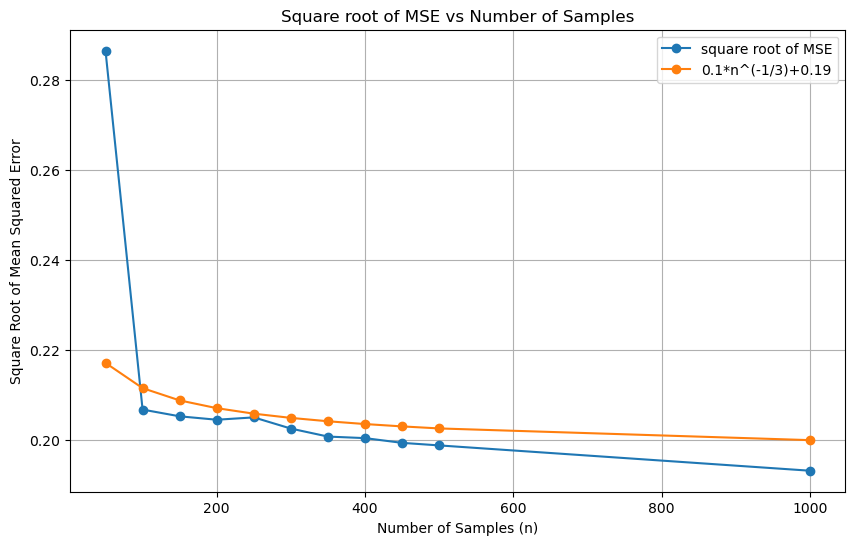

In [25]:
mse_sqrt_values = np.sqrt(mse_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_sqrt_values, marker='o', label="square root of MSE")
plt.plot(n_values, 0.1*np.array(n_values)**(-1/3)+0.19, marker='o', label = "0.1*n^(-1/3)+0.19")
plt.xlabel('Number of Samples (n)')
plt.ylabel('Square Root of Mean Squared Error')
plt.title('Square root of MSE vs Number of Samples')
plt.grid(True)
plt.legend()
plt.show()